In [8]:
from pymongo  import MongoClient
from wordcloud import WordCloud
import pandas as pd
import re
import collections
from pathlib import Path
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import string
import scipy.stats as st
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes, preprocessing, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/souleymbaye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Connexion à la bdd

In [9]:
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC_01"]
collection = db["avis"]

In [10]:
df = pd.DataFrame(list(collection.find()))
df.head(5)

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment
0,63c6726ea81f3e3016af9a56,Monsieur Guillaume,2021-01-27 11:06:44,Voyages sur les ailes des papillons,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,63c6726ea81f3e3016af9a57,morlockbob,2020-10-18 10:04:21,le festival de Michoacan,7.0,https://www.trictrac.net/avis/le-festival-de-m...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Comment continuer après un mega hit ? Simpleme...
2,63c6726ea81f3e3016af9a58,SwatSh,2021-02-01 08:35:08,Vivez la migration des monarques,7.0,https://www.trictrac.net/avis/vivez-la-migrati...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,63c6726ea81f3e3016af9a59,Timi JeuxATheme,2020-11-19 17:04:57,Bon,8.0,None,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN
4,63c6726ea81f3e3016af9a5a,prunelles,2021-05-24 12:43:18,Envolez-moi,9.0,https://www.trictrac.net/avis/envolez-moi,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Très joli bijou que ce jeu-là ! Le matériel, l..."


In [11]:
num_users = len(df["author"].unique())
num_items = len(df["title"].unique())

print(f"there are {num_users} authors and {num_items} items")

there are 13623 authors and 10709 items


In [12]:
print(df.isnull().sum())

_id                   0
author                0
date_published        0
title_review          0
note                  0
review_href       45428
title                 0
url                   0
treated               0
comment           45435
dtype: int64


In [13]:
sparsity = (len(df)/(num_items * num_users))*100
print(f"Rating matrix is only {sparsity}% full")

Rating matrix is only 0.16898086566769008% full


### Repartition des notes

Find the count/mean/std/min/max of the notes

In [14]:
df['note'].describe()

count    246524.00000
mean          7.59307
std           2.12589
min           0.00000
25%           6.00000
50%           8.00000
75%           9.40000
max          10.00000
Name: note, dtype: float64

Skewness empirique, mesure d'asymétrie:

L'asymétrie d'une distribution traduit la régularité ou non avec laquelle les observations se répartissent autour de la valeur centrale

skew = 0 -> symetrique 

skew < 0 -> dstn étalée à gauche (oblique à droite) -> mean < median < mode

In [15]:
df['note'].skew()

-0.9388192907484455

In [16]:
median = df['note'].median()
mean = df['note'].mean()
variance = df['note'].var()
std = df['note'].std()
print("mediane : ", median)
print("moyenne : ", mean)
print("variance : ", variance)
print("ecart-type : ", std)

mediane :  8.0
moyenne :  7.593070451558469
variance :  4.5194064336893405
ecart-type :  2.125889562909922


Distribution globale des notes

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_2607/1446588211.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["note"], bins=10)


<AxesSubplot:xlabel='note', ylabel='Density'>

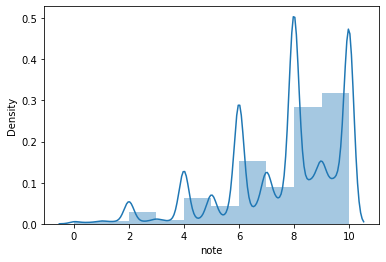

In [17]:
sns.distplot(df["note"], bins=10)

Distribution des notes par autheurs

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_2607/1937457031.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_means,bins=10)


<AxesSubplot:xlabel='note', ylabel='Density'>

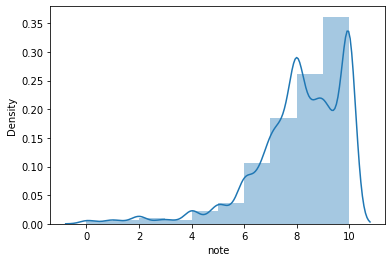

In [18]:
user_means = df.groupby("author")["note"].mean()
sns.distplot(user_means,bins=10)

Distribution des notes par jeux


/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_2607/1777499182.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(item_means,bins=10)


<AxesSubplot:xlabel='note', ylabel='Density'>

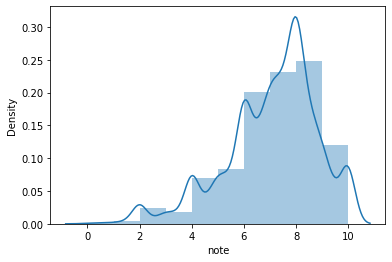

In [19]:
item_means = df.groupby("title")["note"].mean()
sns.distplot(item_means,bins=10)

Built Train/ Test Set

In [20]:
train_indexes,test_indexes = [],[]

for index in range(len(df)):
    if index%5 == 0:
        test_indexes.append(index)
    else:
        train_indexes.append(index)

train_df = df.iloc[train_indexes].copy()
test_df = df.iloc[test_indexes].copy()

Global Training Mean, Global User Mean, Global Item Mean

In [21]:
MEAN = train_df["note"].mean()
USER_MEANS = train_df.groupby("author")["note"].mean()
ITEM_MEANS = train_df.groupby("title")["note"].mean()


def mean_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    return MEAN

def user_mean_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    return USER_MEANS.get(user,default=MEAN)

def item_mean_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    return ITEM_MEANS.get(item,default=MEAN)


In [22]:
test_df["mean_prediction"] = test_df[["author","title"]].apply(mean_rating_pred,axis=1)
test_df["muser_prediction"] = test_df[["author","title"]].apply(user_mean_rating_pred,axis=1) 
test_df["mitem_prediction"] = test_df[["author","title"]].apply(item_mean_rating_pred,axis=1) 

test_df.head(5)

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment,mean_prediction,muser_prediction,mitem_prediction
0,63c6726ea81f3e3016af9a56,Monsieur Guillaume,2021-01-27 11:06:44,Voyages sur les ailes des papillons,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Lorsque le jeu est jeu, bon, réflexif, joli po...",7.595337,7.831132,7.392405
5,63c6726ea81f3e3016af9a5b,BSI40,2022-09-23 17:16:27,Manque un peu de souffle,7.0,https://www.trictrac.net/avis/manque-un-peu-de...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Mariposas est plutôt beau avec un grand platea...,7.595337,7.754588,7.392405
10,63c6726ea81f3e3016af9a60,Max Riock,2020-11-25 17:36:15,Vraiment bon,9.0,None,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN,7.595337,8.775882,7.392405
15,63c6726ea81f3e3016af9a65,Lilly,2020-11-03 17:30:05,Beau et Doux et Rapide,8.0,https://www.trictrac.net/avis/bon-14639,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Mariposas est un jeu ou la tension va s'exacer...,7.595337,7.920000,7.392405
20,63c6726ea81f3e3016af9a6a,AtomChris,2022-01-21 13:48:38,Le battement d'ailes du papillon...,8.0,https://www.trictrac.net/avis/le-battement-dai...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,2° partie testée en solo pour explications fut...,7.595337,8.000000,7.392405


In [23]:
details = db["details"]
df_details = pd.DataFrame(list(details.find()))
df_details.head(5)


,_id,categories,casting,gameplay,description,full_title,titre,url,Note,Note rectifiée,Note Finkel,Nombre d'avis,Nombre d'avis rectifiés
0,63c5790a08b9fb9fd8f26ec8,,Par Eric Lang et Andrea ChiarvesioIllustré par...,1 à 4|14 ans et +|45,\n Marvel United : Unis c...,Marvel United (2020),Marvel United,https://www.trictrac.net/jeu-de-societe/marvel...,7.58,8.40,8.74,19.0,10.0
1,63c5790a08b9fb9fd8f26ec9,,Par Elizabeth HargraveIllustré par Matt Paquet...,2 à 5|14 ans et +|60,"\n Chaque année, au print...",Mariposas (2020),Mariposas,https://www.trictrac.net/jeu-de-societe/mariposas,7.39,7.29,7.68,33.0,17.0
2,63c5790b08b9fb9fd8f26eca,Enchères|Aventures dans la jungle|Collection /...,Par Alexandre GarciaIllustré par Nastya LehnÉd...,2 à 5|8 ans et +|45,\n Vous êtes à la tête d’...,Quetzal (2020),Quetzal,https://www.trictrac.net/jeu-de-societe/quetzal,8.18,7.22,7.42,28.0,9.0
3,63c5790b08b9fb9fd8f26ecb,,Édité par Arkhane Asylum Publishing,à partir de 1|12 ans et +|~,\n Un Kit de démarrage co...,Alien - Kit de Démarrage (2020),Alien - Kit de Démarrage,https://www.trictrac.net/jeu-de-societe/alien-...,9.00,0.00,0.00,4.0,0.0
4,63c5790b08b9fb9fd8f26ecc,Card-driven|Combinaison|Coopération|Deck build...,Par Maxime Rambourg et Théo RivièreIllustré pa...,1 à 4|12 ans et +|60,\n Le Dr Foo a créé une t...,The LOOP (2020),The LOOP,https://www.trictrac.net/jeu-de-societe/the-loop,8.75,8.79,9.70,72.0,24.0


### Jeux les mieux notés

In [24]:
df_details.sort_values(by='Note', ascending=False, inplace=True)
df_details[['titre', 'Note']]

,titre,Note
11583,Samurai - The Card Game,10.0
12607,Shadowrun : The Trading Card Game,10.0
12264,Logeo profi,10.0
16787,1825 - Unit 1,10.0
14494,Alexander the Great,10.0
...,...,...
10926,Sur les Traces des Animaux... d'Afrique,0.0
10933,Tschu-Tschu,0.0
10935,Mon premier Uno avec Dora l'Exploratrice,0.0
10939,Gauss,0.0


In [25]:
tmp_df = pd.DataFrame()
titres = list(df_details.titre)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = titres[((i-1)*10) : i*10]
tmp_df.head(5)

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,Samurai - The Card Game,Might & Magic Heroes - The board game,Splendor - Goodie Tuile Noble : Jacques Cartier,Wings of Glory : WW2 Miniatures Airplane Packs...,EastFront - Seconde édition,Pathfinder : Manuel des joueurs règles avancées,Age of Steam : Expansions France & Italy,The BattleTech 25th Anniversary Introductory B...,10 000,The Hellgame - Extra Evil
1,Shadowrun : The Trading Card Game,El Capitan Alatriste,Star Realms Tapis,Crapules,Batailles fantastiques : Le Neuvième Âge,Reportages,"La Croix et l'Épée - Las Navas de Tolosa, 1212",Batailles fantastiques : Le Neuvième Âge,Grant Takes Command,Le Bourru
2,Logeo profi,Larguez les amarres !,Karnag-Les congrégations,Sidoké,Coloretto : The Extra Cards,Les chats de Kilkenny,Duck! Duck! Go!,Les pieds dans le plat,Thalie,"The Drive on Metz ,1944"
3,1825 - Unit 1,Revolver: Vengeance on the Frontier,Banana Jump,Flying Lead,Mao,Emmerlaüs : Le Destin,Meuh où est La vache qui rit?,Diaballik,Flouk zybrydes,L'Appel de Cthulhu JCE : Chuchotements dans le...
4,Alexander the Great,L'auto écolo,Dungeons & Dragons Miniatures : Unhallowed,BIVARY,Frédéric II : La Guerre de Sept Ans,Great War Commander,Dungeon Twister : L'elfe des bois,Athena,Warhammer patrouilles,Great War Commander


### Jeux avec le plus d'avis

In [26]:
df_details.sort_values(by='Nombre d\'avis', ascending=False, inplace=True)
df_details[['titre', 'Nombre d\'avis']]

,titre,Nombre d'avis
4204,Citadelles : quatrième édition,1452.0
658,Citadelles : quatrième édition,1452.0
1764,Carcassonne,1263.0
5792,Carcassonne,1263.0
7371,Small World,1251.0
...,...,...
6617,Zombies!!! 12 : Zombies Zoo,0.0
6613,Match'n'Turn,0.0
6530,Aisopos,0.0
6529,Android : Netrunner - Trace Amount,0.0


In [27]:
tmp_df = pd.DataFrame()
titres = list(df_details.titre)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = titres[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,Citadelles : quatrième édition,7 Wonders Duel,Mysterium,Munchkin,Colt Express,Skull,Ghost Stories,Terraforming Mars,Ca$h'n Guns second édition,Il était une fois
1,Citadelles : quatrième édition,Jungle Speed,Bang!,Saboteur,Bohnanza,Tigris & Euphrates,Sherlock Holmes Détective Conseil : les meurtr...,Gang Of Four,Ca$h'n Guns second édition,Il était une fois
2,Carcassonne,Jungle Speed,Splendor,Elixir,Abyss,Tigris & Euphrates,Sherlock Holmes Détective Conseil : les meurtr...,Concept,Taluva,Can't Stop
3,Carcassonne,Agricola,Splendor,Dominion,Abyss,Formula D,Uno Deluxe,Service Compris !,L'Île interdite,T.I.M.E Stories
4,Small World,Agricola,Caylus,Dominion,Schotten-Totten,Lost Cities - The Boardgame,Five Tribes,Concept,Taluva,Fantasy
5,Les Aventuriers du Rail,Dixit,Takenoko,Race for the Galaxy,Schotten-Totten,Hanabi,Five Tribes,Service Compris !,Dice Town,T.I.M.E Stories
6,Catan,Dixit,Time's Up !,L'Âge de Pierre,Dungeon Twister 2 - Prison,Hanabi,Lords of Xidit,The Island,Dice Town,Mille Bornes - Fun & Speed - Voyage
7,Catan,6 qui prend !,Les Chevaliers de la Table Ronde,King of Tokyo,Camelot,Mr. Jack Pocket,Lords of Xidit,Troyes,Échecs,Mille Bornes - Fun & Speed - Voyage
8,Pandémie,Mr. Jack - London,Jamaïca,King of Tokyo,Camelot,Myrmes,Seasons,Zombicide,Las Leyendas de Andor,La Crique des Pirates
9,7 Wonders Duel,Mysterium,La Guerre des Moutons,Colt Express,Skull,Cyclades,Terraforming Mars,Mémoire 44,Las Leyendas de Andor,Augustus


### Vocabulaire

In [28]:
df = df.copy()
df['comment'] = df['comment'].astype(str)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.comment)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))

Taille initiale du vocabulaire : 140837


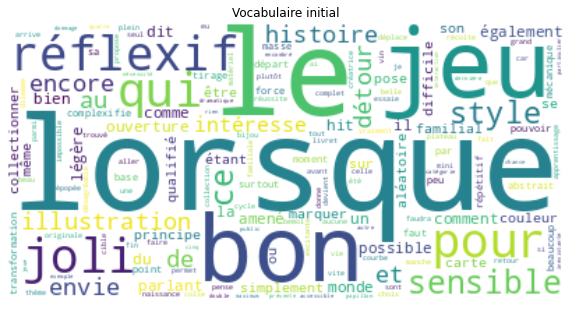

In [29]:
wc = WordCloud(background_color="white").generate(' '.join(vectorizer.vocabulary_.keys()))
plt.figure(figsize=(10, 8))
plt.title('Vocabulaire initial')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

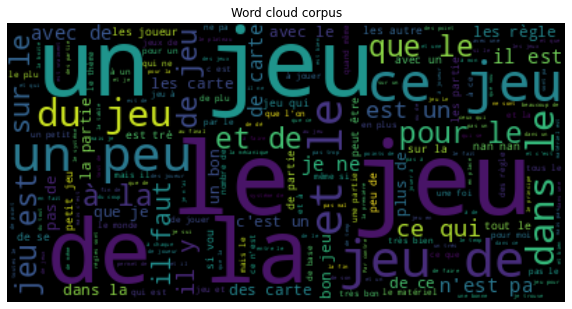

In [30]:
wc = WordCloud().generate(' '.join(df.comment))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 100 mots les plus frequents

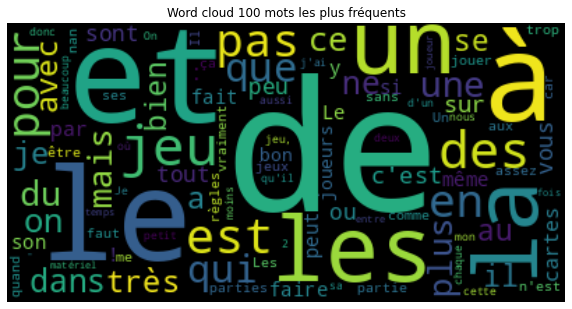

In [31]:
words = " ".join(df.comment).split()
word_counter = Counter(words)

top_100_words = dict(word_counter.most_common(100))

wc = WordCloud().generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 mots les plus fréquents')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [32]:
tmp_df = pd.DataFrame()
top_100_words = list(top_100_words)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = top_100_words[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,de,pas,mais,se,par,bon,trop,assez,moins,cette
1,et,pour,ne,c'est,même,joueurs,aux,n'est,sa,-
2,le,en,dans,sur,fait,partie,faut,Il,Je,d'un
3,à,que,avec,sont,si,ça,vraiment,car,On,chaque
4,les,qui,a,tout,!,jouer,comme,quand,nous,où
5,la,une,je,ou,peut,nan,Un,petit,deux,matériel
6,un,du,très,:,y,Les,règles,aussi,j'ai,temps
7,jeu,on,il,vous,son,parties,me,donc,mon,joueur
8,des,plus,au,peu,Le,jeux,être,qu'il,"jeu,",entre
9,est,ce,bien,cartes,faire,sans,ses,2,beaucoup,fois


### Bigramme

In [33]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(df.comment)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

,bigram,frequency
0,le jeu,92330
1,un jeu,87181
2,de la,72574
3,ce jeu,62595
4,un peu,58389
...,...,...
95,qui ne,10910
96,les jeux,10781
97,je trouve,10729
98,beaucoup de,10710


In [34]:
tmp_df = pd.DataFrame()
bigrams = list(top_100_bigrams_df.bigram)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,le jeu,de jeu,je ne,avec des,de ce,avec un,ne pas,jeux de,une fois,est une
1,un jeu,qu il,les règles,que le,jeu qui,pas de,le matériel,le plus,et est,quand même
2,de la,il faut,des cartes,que les,plus de,pour le,peu de,même si,ce que,des règles
3,ce jeu,il est,les cartes,est très,les parties,on est,je ai,de plus,pour un,jeu et
4,un peu,ce qui,on peut,de cartes,peut être,dans les,le thème,en plus,et des,je suis
5,jeu de,et de,dans la,un bon,les autres,sur la,tout le,très bon,le monde,qui ne
6,est un,dans le,et le,bon jeu,on se,si on,avec les,de jouer,pour moi,les jeux
7,jeu est,qu on,sur le,on ne,que on,si vous,un petit,de base,très bien,je trouve
8,du jeu,pour les,la partie,qui est,et on,une partie,sur les,est bien,est le,beaucoup de
9,est pas,et les,que je,les joueurs,et la,petit jeu,tous les,ce est,nombre de,le plateau


### Trigramme

In [35]:
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(df.comment)

trigram_frequencies = np.array(X.sum(axis=0))[0]
trigram_frequencies_sorted = (-trigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_trigrams_df = pd.DataFrame()
top_100_trigrams_df['trigram'] = [features[i] for i in trigram_frequencies_sorted[:100]]
top_100_trigrams_df['frequency'] = [trigram_frequencies[i] for i in trigram_frequencies_sorted[:100]]
top_100_trigrams_df

,trigram,frequency
0,le jeu est,23296
1,un jeu de,19400
2,est un jeu,18339
3,ce jeu est,14122
4,tout le monde,9937
...,...,...
95,je trouve que,2586
96,un bon moment,2564
97,prise de tête,2552
98,durée de vie,2551


In [36]:
tmp_df = pd.DataFrame()
trigrams = list(top_100_trigrams_df.trigram)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = trigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,le jeu est,les règles sont,jeu de base,autour de la,je ne suis,ne suis pas,un peu trop,il est pas,en même temps,plus ou moins
1,un jeu de,un bon jeu,je ai pas,qu il faut,dans ce jeu,pas du tout,est pas un,il ne faut,pour ne pas,ce qu on
2,est un jeu,le jeu de,un petit jeu,le nombre de,fin de partie,en fin de,les autres joueurs,des jeux de,le fait de,des points de
3,ce jeu est,ce qui est,de la table,de ne pas,je me suis,bon jeu de,jeu est pas,la première partie,je pense que,la possibilité de
4,tout le monde,très bon jeu,un peu plus,le système de,du jeu de,la fin de,plateau de jeu,en tout cas,que les autres,temps en temps
5,ce est pas,de la partie,tout de même,jeu de cartes,pas mal de,mise en place,un jeu très,les cartes sont,tout de suite,je trouve que
6,un peu de,que le jeu,qu il est,les jeux de,on ne peut,points de victoire,pas grand chose,jeu de gestion,jeu est un,un bon moment
7,un jeu qui,ne sont pas,les parties sont,le thème est,jeu est très,un excellent jeu,et le jeu,entre les joueurs,bon petit jeu,prise de tête
8,le matériel est,un très bon,du jeu est,ce qu il,petit jeu de,le jeu en,pour ceux qui,est un bon,de temps en,durée de vie
9,de ce jeu,est un peu,pour un jeu,dans le jeu,que ce jeu,sur le plateau,de jeu est,si vous avez,le jeu se,qui permet de


### stopwords

In [37]:
stops_words_french = stopwords.words('french')
others_stops_words = ["a", "as", "ai", "au", "aux", "avec", "ce", "ces", "dans", "de", "des",
                      "du", "elle", "en", "et", "eux", "il", "je", "la", "le", "leur", "lui", 
                      "ma", "mais", "me", "même", "mes", "moi", "mon", "ne", "nos", "notre", 
                      "nous", "on", "ou", "par", "pas", "pour", "qu", "que", "qui", "sa", "se", 
                      "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu", "un", "une", 
                      "vos", "votre", "vous", "c", "d", "j", "l", "à", "m", "n", "s", "t", "y", 
                      "été", "étée", "étées", "étés", "étant", "suis", "es", "est", "sommes", "êtes", 
                      "sont", "serai", "seras", "sera", "serons", "serez", "seront", "serais", "serait", 
                      "serions", "seriez", "seraient", "étais", "était", "étions", "étiez", 
                      "étaient", "fus", "fut", "fûmes", "fûtes", "furent", "sois", "soit", 
                      "soyons", "soyez", "soient", "fusse", "fusses", "fût", "fussions", 
                      "fussiez", "fussent", "ayant", "eu", "eue", "eues", "eus", "ai", "as", 
                      "avons", "avez", "ont", "aurai", "auras", "aura", "aurons", "aurez", 
                      "auront", "aurais", "aurait", "aurions", "auriez", "auraient", "avais", 
                      "avait", "avions", "aviez", "avaient", "eut", "eûmes", "eûtes", "eurent", 
                      "aie", "aies", "ait", "ayons", "ayez", "aient", "eusse", "eusses", "eût", 
                      "eussions", "eussiez", "eussent",
                      #
                      "comme", "comment", "cependant", "parce", "dont", "aussi", "cette",
                      "aujourd", "hui", "dont", "ceci", "cela", "celle", "celui", "ceux", "celles",
                      "pourquoi", "quand", "tout", "toute", "tous", "toutes"]
stops_words_french = sorted( list( set(stops_words_french + others_stops_words) ) )
len(stops_words_french)

179

In [38]:
def delete_stop_word(doc, stop_words=stops_words_french):
    doc = re.sub(r'[\W_]+', ' ', doc)
    return ' '.join([word for word in doc.split() if word.lower() not in stop_words])

In [39]:
corpus = df.comment.map(delete_stop_word)

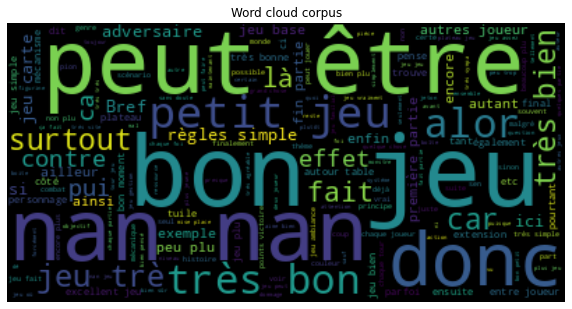

In [40]:
wc = WordCloud().generate(' '.join(corpus))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

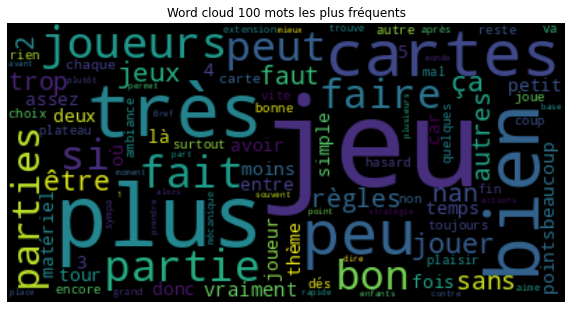

In [41]:
words = " ".join(corpus).split()
word_counter = Counter(words)

top_100_words = dict(word_counter.most_common(100))

wc = WordCloud().generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 mots les plus fréquents')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
tmp_df = pd.DataFrame()
top_100_words = list(top_100_words)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = top_100_words[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,jeu,peut,trop,petit,joueur,plateau,choix,fin,plutôt,enfants
1,plus,faire,sans,moins,5,bonne,non,extension,alors,1
2,bien,bon,faut,temps,points,autre,quelques,grand,contre,Bref
3,très,parties,2,3,thème,encore,reste,trouve,place,permet
4,cartes,jouer,autres,4,où,toujours,va,mécanique,part,avant
5,peu,ça,vraiment,simple,tour,plaisir,mal,aime,actions,mieux
6,joueurs,être,assez,beaucoup,entre,vite,ambiance,après,base,prendre
7,partie,jeux,donc,matériel,là,joue,rien,sympa,monde,plusieurs
8,fait,nan,deux,fois,chaque,hasard,coup,stratégie,rapide,souvent
9,si,règles,car,avoir,carte,dés,surtout,dire,moment,point


### odds ratio

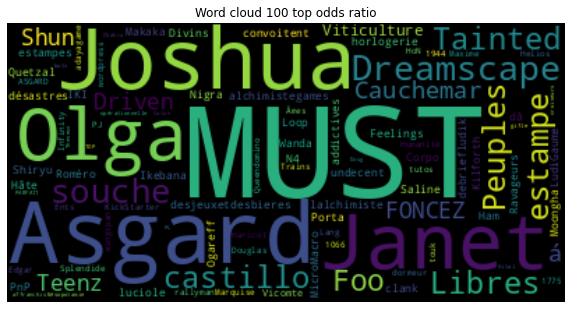

In [43]:
corpus_notes_positives = corpus[df.note >= mean]
corpus_notes_negatives = corpus[df.note < mean]

class1_words = ' '.join(corpus_notes_positives).split()
class2_words = ' '.join(corpus_notes_negatives).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud().generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

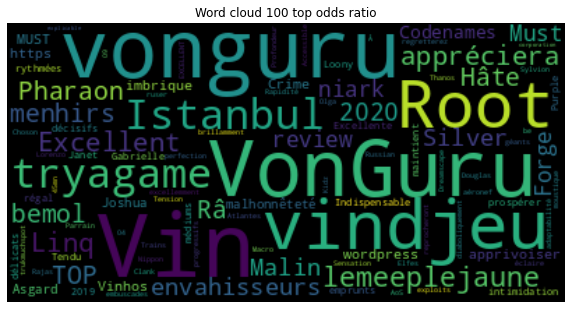

In [44]:
corpus_notes_positives = corpus[df.note >= 5]
corpus_notes_negatives = corpus[df.note < 5]

class1_words = ' '.join(corpus_notes_positives).split()
class2_words = ' '.join(corpus_notes_negatives).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud().generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 100 mots les plus frequents par note

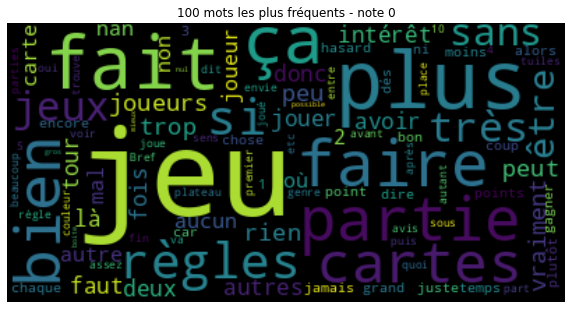

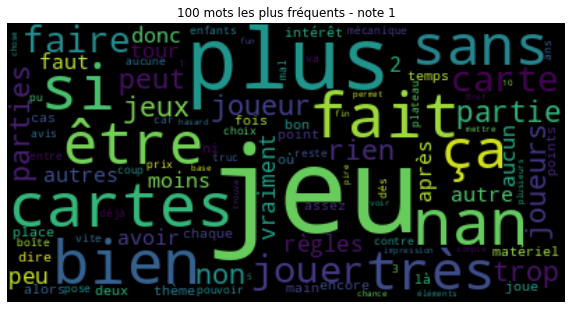

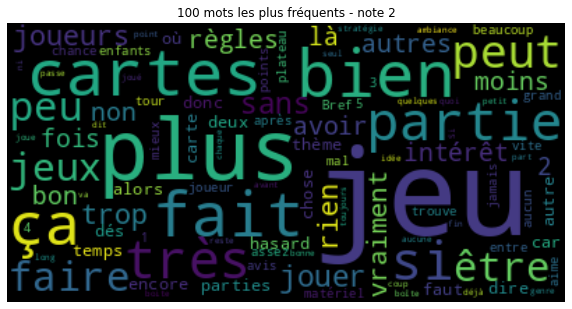

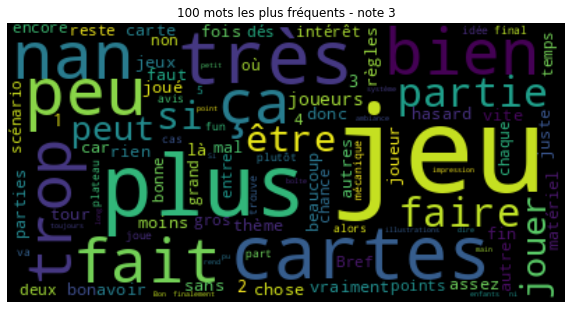

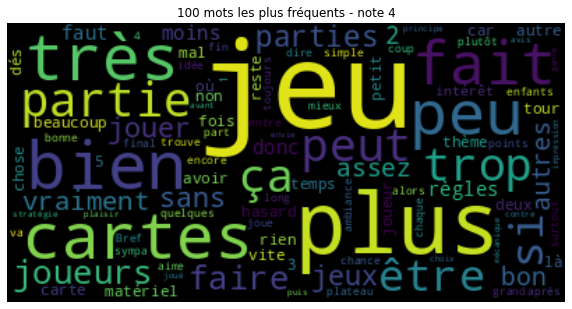

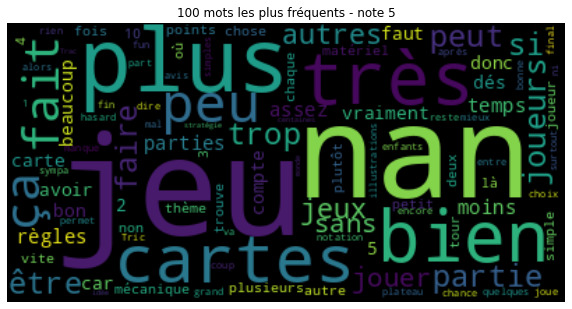

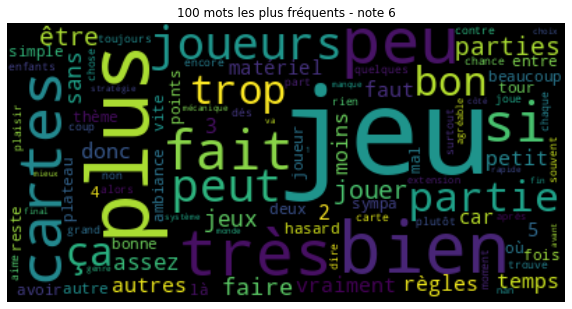

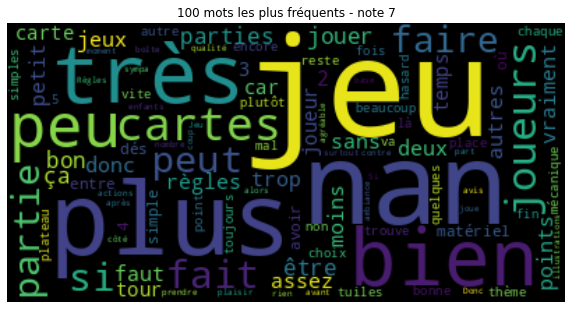

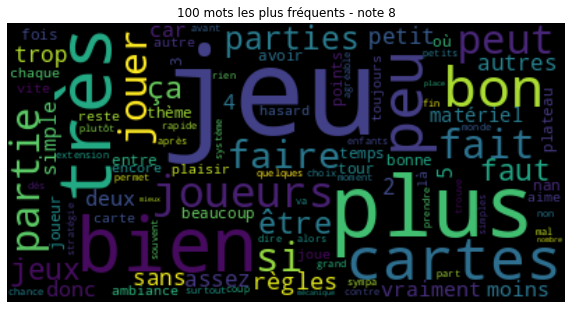

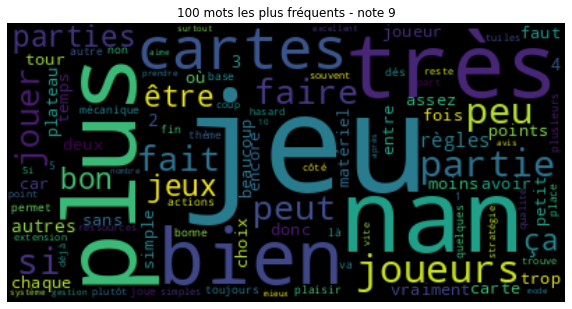

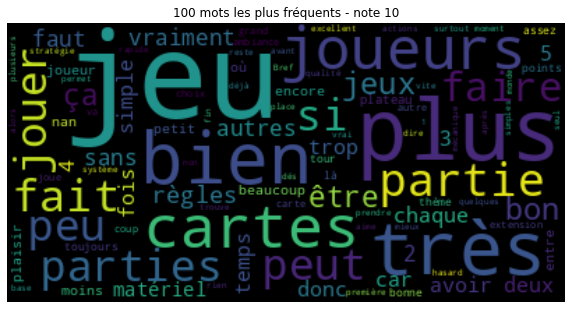

In [45]:
for i in range(0,11):
    corpus_notes = corpus[df.note == i]
    words = " ".join(corpus_notes).split()
    word_counter = Counter(words)

    top_100_words = dict(word_counter.most_common(100))

    wc = WordCloud().generate_from_frequencies(top_100_words)
    plt.figure(figsize=(10, 8))
    plt.title(f'100 mots les plus fréquents - note {i}')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()